In [5]:
!pip3 install opencv-python

--- Logging error ---
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/Library/

In [27]:
import os
import time
import uuid
import cv2


In [28]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [173]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


: 

In [110]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [86]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


In [87]:
tf.config.list_physical_devices('GPU')

[]

In [88]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle = False) #For Windows, do "\\" instead of /

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data/images/*.jpg'

In [33]:
images.as_numpy_iterator().next()

b'data/images/5c3f8e68-7036-11ed-930b-3e22fb7d61b8.jpg'

In [89]:
def load_image(x):
    byte_img = tf.io.read_file(x) #Takes in file path and returns a byte encoded image
    img = tf.io.decode_jpeg(byte_img) #parses through the byte image
    return img

In [90]:
images = images.map(load_image) #Applies the load image function to each file in the dataset

TypeError: in user code:

    File "/var/folders/yb/8kms7xf112sbj6s82v78g1vw0000gn/T/ipykernel_15011/3491971534.py", line 2, in load_image  *
        byte_img = tf.io.read_file(x) #Takes in file path and returns a byte encoded image

    TypeError: Input 'filename' of 'ReadFile' Op has type uint8 that does not match expected type of string.


In [91]:
images.as_numpy_iterator().next()

2022-11-30 17:32:16.662195: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/5e4f8686-7036-11ed-930b-3e22fb7d61b8.jpg; No such file or directory
2022-11-30 17:32:16.662233: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/5cf0e01e-7036-11ed-930b-3e22fb7d61b8.jpg; No such file or directory
2022-11-30 17:32:16.662272: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/5fffbe74-7036-11ed-930b-3e22fb7d61b8.jpg; No such file or directory
2022-11-30 17:32:16.662292: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/5df9041e-7036-11ed-930b-3e22fb7d61b8.jpg; No such file or directory
2022-11-30 17:32:16.662327: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FO

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} data/images/5c3f8e68-7036-11ed-930b-3e22fb7d61b8.jpg; No such file or directory
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

In [ ]:
image_generator = images.batch(4).as_numpy_iterator() #Batches images up. Rather than returning 1 image, it will return the number of values inside of a batch

In [92]:
plot_images = image_generator.next()

2022-11-30 17:32:18.532808: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/646868bc-7036-11ed-930b-3e22fb7d61b8.jpg; No such file or directory
2022-11-30 17:32:18.532828: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/656b96c6-7036-11ed-930b-3e22fb7d61b8.jpg; No such file or directory
2022-11-30 17:32:18.532841: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/6515126a-7036-11ed-930b-3e22fb7d61b8.jpg; No such file or directory
2022-11-30 17:32:18.532859: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: data/images/64be8aee-7036-11ed-930b-3e22fb7d61b8.jpg; No such file or directory


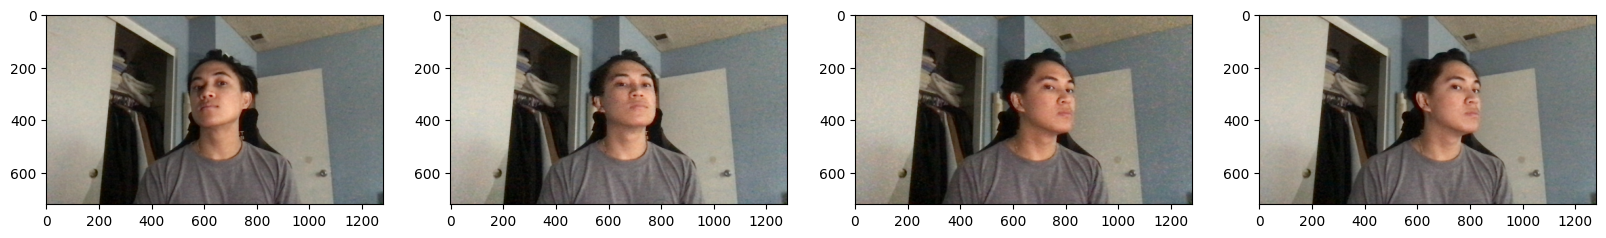

In [93]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

Partitioning Unaugmented Data
Send 70% to train folder and 15% to test and val

In [94]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)
#Moves the labels fromthe raw folder to their corresponding images

In [95]:
import albumentations as alb

In [96]:
augmentor = alb.Compose([
    alb.RandomCrop(width=450, height=450), 
    alb.HorizontalFlip(p=0.5),
    alb.RandomBrightnessContrast(p=0.2),
    alb.RandomGamma(p=0.2), 
    alb.RGBShift(p=0.2),
    alb.VerticalFlip(p=0.5)],
    bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

In [97]:
img = cv2.imread(os.path.join('data', 'train', 'images', '7f3bab18-7036-11ed-930b-3e22fb7d61b8.jpg'))

In [98]:
img.shape

(720, 1280, 3)

In [99]:
with open(os.path.join('data', 'train', 'labels', '7f3bab18-7036-11ed-930b-3e22fb7d61b8.json'), 'r') as f:
    label = json.load(f)

In [100]:
label['shapes'][0]['points']

[[545.7971014492753, 120.86956521739131],
 [851.5942028985506, 467.24637681159425]]

In [101]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1] 
#Extracts coordinates and rescales to match image resolution
#This returns a vector with all of our coordinates

In [102]:
coords = list(np.divide(coords, [1280, 720, 1280, 720]))

In [103]:
coords

[0.4264039855072463,
 0.16787439613526572,
 0.6653079710144927,
 0.6489533011272143]

In [104]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face']) 

In [105]:
augmented['bboxes']

[(0.42090177133655415, 0.3527858293075682, 1.0, 1.0)]

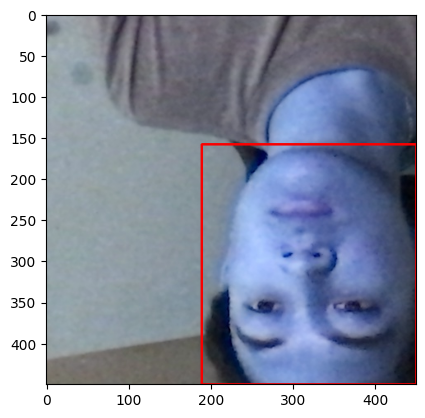

In [106]:
cv2.rectangle(augmented['image'],
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)), #Gets the first two coordinates
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)), #Gets the last two coordinates
                    (250,0,0), 2)
plt.imshow(augmented['image'])

Running the Augmentation Pipeline


In [132]:
for partition in ['train', 'test', 'val']:
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001, 0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1] 
            coords = list(np.divide(coords, [1280, 720, 1280, 720]))
        try:
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image
                
                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0:
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0
                    else:
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else:
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 #Writing down the annotations on the bbox

                with open(os.path.join('aug+data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation,f)

        except Exception as e:
            print(e)


[Errno 2] No such file or directory: 'aug+data/train/labels/7e8f10c4-7036-11ed-930b-3e22fb7d61b8.0.json'
[Errno 2] No such file or directory: 'aug+data/train/labels/5fa980e0-7036-11ed-930b-3e22fb7d61b8.0.json'
[Errno 2] No such file or directory: 'aug+data/train/labels/7f3bab18-7036-11ed-930b-3e22fb7d61b8.0.json'
[Errno 2] No such file or directory: 'aug+data/train/labels/97ad6526-7061-11ed-ba31-3e22fb7d61b8.0.json'
[Errno 2] No such file or directory: 'aug+data/train/labels/9653b02c-7061-11ed-ba31-3e22fb7d61b8.0.json'
[Errno 2] No such file or directory: 'aug+data/train/labels/7b804ccc-7036-11ed-930b-3e22fb7d61b8.0.json'
[Errno 2] No such file or directory: 'aug+data/train/labels/62b7df3e-7036-11ed-930b-3e22fb7d61b8.0.json'
[Errno 2] No such file or directory: 'aug+data/train/labels/990718ae-7061-11ed-ba31-3e22fb7d61b8.0.json'
[Errno 2] No such file or directory: 'aug+data/train/labels/65c1d860-7036-11ed-930b-3e22fb7d61b8.0.json'
[Errno 2] No such file or directory: 'aug+data/train/la

Loads Augmented Images to TensorFlow Dataset


In [133]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [134]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [135]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [136]:
train_images.as_numpy_iterator().next()

array([[[0.6338235 , 0.58860296, 0.49172795],
        [0.627451  , 0.5857843 , 0.5042892 ],
        [0.6179534 , 0.5865809 , 0.50422794],
        ...,
        [0.84767157, 0.6433824 , 0.57395834],
        [0.8208333 , 0.62806374, 0.5613971 ],
        [0.8331495 , 0.64191175, 0.5724878 ]],

       [[0.62169117, 0.5740196 , 0.475     ],
        [0.59552693, 0.5518382 , 0.4666054 ],
        [0.6043505 , 0.5602328 , 0.48229167],
        ...,
        [0.8101103 , 0.62628675, 0.55667895],
        [0.746201  , 0.54718137, 0.48063725],
        [0.5951593 , 0.38897058, 0.32034314]],

       [[0.6161765 , 0.55735296, 0.46715686],
        [0.59068626, 0.54362744, 0.45735294],
        [0.5808824 , 0.529902  , 0.45539215],
        ...,
        [0.7468137 , 0.5768995 , 0.5106618 ],
        [0.6657475 , 0.47457108, 0.41525736],
        [0.6105392 , 0.3944853 , 0.33376226]],

       ...,

       [[0.07156863, 0.06764706, 0.05686275],
        [0.07052696, 0.06660539, 0.05091912],
        [0.05140932, 0

Preparing Labels


In [137]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)

    return [label['class']], label['bbox']

In [138]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: aug_data/train/labels/*.json'

In [ ]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

Combine Label and Image Samples

In [ ]:
len(train_images), len(train_labels), len(test_images) #Checking the amount of images we have

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4) #Helps eliminate bottlenecks

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test= test.shuffle(1300)
test = test.batch(8)
test= test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val= val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

View images and annotations

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

Building the Deep elarning model using Functional API

In [130]:
from tensorflow.python import keras
from tensorflow.python.keras.layers import Input, Dense, Conv2D, GlobalMaxPooling2D
from tensorflow.python.keras.models import Model
from keras.applications import VGG16


In [131]:
vgg = VGG16(include_top = False)

58889256/58889256 [==============================] - 45s 1us/step


In [122]:
def build_model():  #once we taken in the input layer, we pass it into the vgg16 layer
    input_layer = Input(shape=(120,120,3))
    
    #Creating the layer, and telling the layer what we are gong to pass through it
    vgg = VGG16(include_top=False)(input_layer)

    #Classification model  
    f1 = GlobalMaxPooling2D()(vgg) #Looking across all chanells of the VGG output and only returning the max values
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    #Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1) 
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2]) #These outputs match what the annotations look like
    return facetracker


In [ ]:
facetracker = build_model()

In [ ]:
x,y = train.as_numpy_iterator().next()


In [ ]:
classes, coords = facetracker.predict(x)

Defining Losses and optimizers

In [ ]:
batches_per_epoch = 690
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimzers.Adam(learning_rate = 0.0001, decay = lr_decay)

In [ ]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size


In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss


In [ ]:
localization_loss(y[1], coords)


In [ ]:
classloss(y[0], classes)


In [ ]:
regressloss(y[1], coords)


In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True) #Makes a preiction from the model
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)


In [ ]:
model.compile(opt, classloss, regressloss)


In [ ]:
logdir='logs'


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)


In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])


In [ ]:
hist.history


In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [ ]:
test_data = test.as_numpy_iterator()


In [ ]:
test_sample = test_data.next()


In [ ]:
yhat = facetracker.predict(test_sample[0])


In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [ ]:
from tensorflow.keras.models import load_model


In [ ]:
facetracker.save('facetracker.h5')


In [ ]:
facetracker = load_model('facetracker.h5')


In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()